In [1]:
from google.colab import drive
drive.mount('/gdrive')
!unzip -qq /gdrive/MyDrive/ResearchNotebooks/Dataset/Tubule_1/AllPatchesImageAndMasks.zip -d /content

Mounted at /gdrive


In [2]:
import os
import cv2
import sys
import random
from skimage.io import imread,imshow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split

from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Permute, Activation, Input,add, multiply
from keras.callbacks import CSVLogger, ReduceLROnPlateau, ModelCheckpoint,EarlyStopping
from keras.layers import concatenate, core, Dropout
from keras.models import Model

from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.core import Lambda
import keras.backend as K

seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

train_ratio = 0.70
validation_ratio = 0.10
test_ratio = 0.20

In [3]:
x = []; y = []
images = sorted(os.listdir('/content/image'))
masks = sorted(os.listdir('/content/mask'))
for image in images:
  img = cv2.imread('/content/image/' + image)
  x.append(img)
  x.append(cv2.flip(img, 0))
  x.append(cv2.flip(img, -1))
  x.append(cv2.flip(img, 1))
  msk = cv2.imread('/content/mask/'+ image[:-6] + '_anno-' + image[-5] + '.png',0).reshape(256,256,1)
  y.append(msk)
  y.append(cv2.flip(msk, 0).reshape(256,256,1))
  y.append(cv2.flip(msk, -1).reshape(256,256,1))
  y.append(cv2.flip(msk, 1).reshape(256,256,1))
x = np.asarray(x); y = np.asarray(y)/255

In [4]:
'''x = np.load('/gdrive/MyDrive/ResearchNotebooks/Dataset/Tubule_1/X_Tubule_256x256_480_Augmented_v1_NoNormal.npy')/255
y = np.load('/gdrive/MyDrive/ResearchNotebooks/Dataset/Tubule_1/Y_Tubule_256x256_480_Augmented_v1_NoNormal.npy')/255
print("Shapes:",x.shape[0], y.shape[0])
if x.shape == (480, 256, 256, 3) and y.shape == (480, 256, 256, 1):
  print('Dataset Loaded!')'''

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_ratio, random_state = 42, shuffle = True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 42, shuffle = True) 
print('Data Split!')
print(len(x_train),len(x_test), len(x_valid))
print(x_train[0].shape, y_train[0].shape)

Data Split!
1343 385 192
(256, 256, 3) (256, 256, 1)


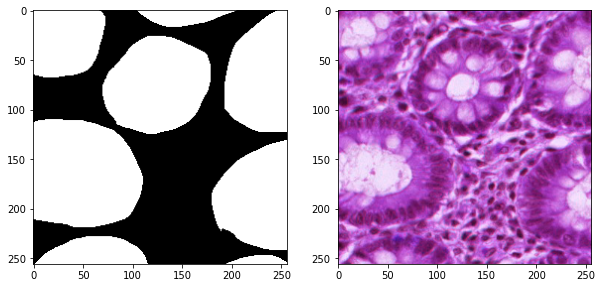

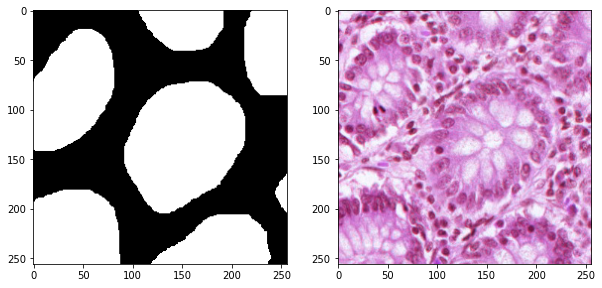

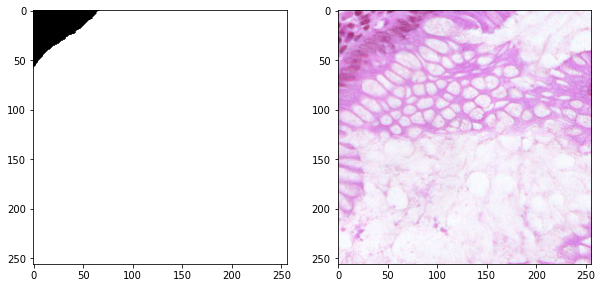

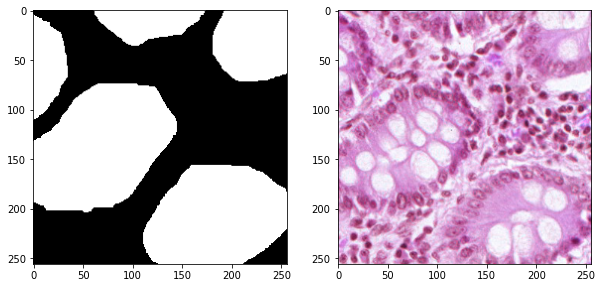

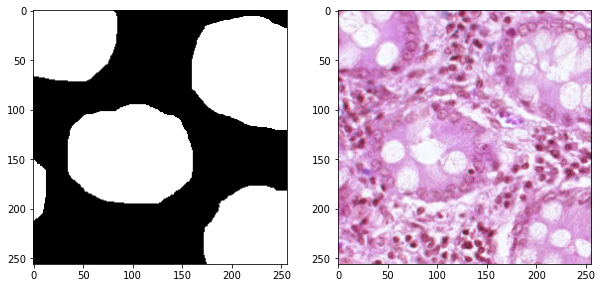

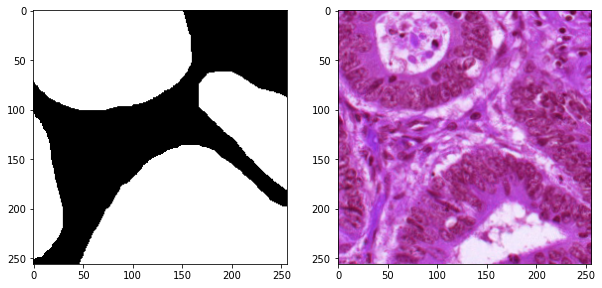

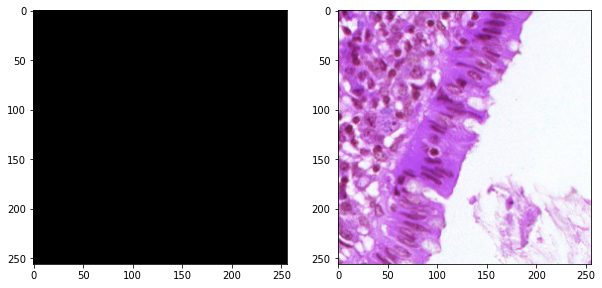

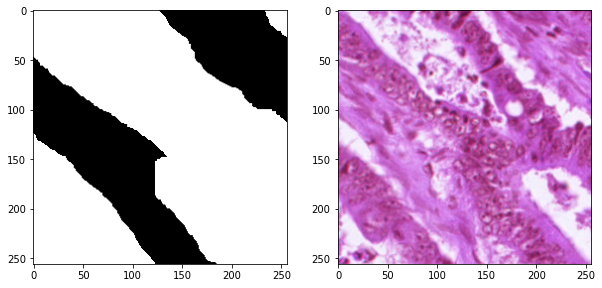

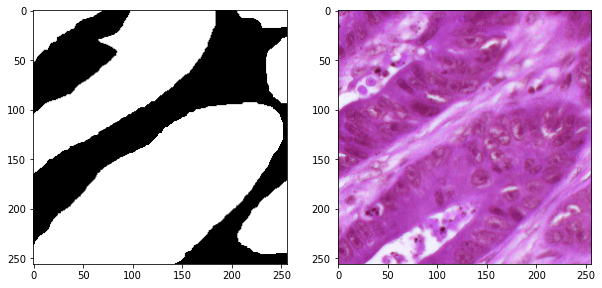

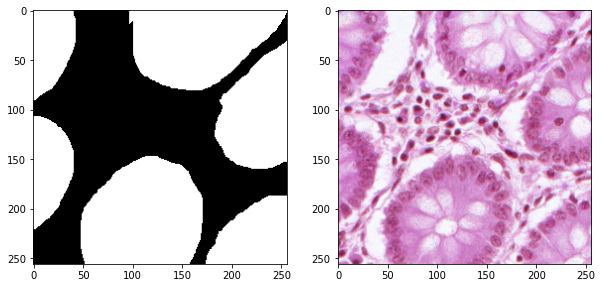

In [5]:
for i in range(10,20):
  fig=plt.figure(figsize=(10,10))
  b=fig.add_subplot(1,2,1)
  b.imshow(y_train[i].reshape(256,256),cmap="gray")
  b=fig.add_subplot(1,2,2)  
  b.imshow(x_train[i])

In [6]:
def up_and_concate(down_layer, layer):
    in_channel = down_layer.get_shape().as_list()[3]
    up = UpSampling2D(size=(2, 2))(down_layer)
    my_concat = Lambda(lambda x: K.concatenate([x[0], x[1]], axis=3))
    concate = my_concat([up, layer])
    return concate
  
def rec_res_block(input_layer, out_n_filters, batch_normalization=False, kernel_size=[3, 3], stride=[1, 1],padding='same'):
  #print(input_layer.get_shape())
  input_n_filters = input_layer.get_shape().as_list()[3]

  if out_n_filters != input_n_filters:
      skip_layer = Conv2D(out_n_filters, [1, 1], strides=stride, padding=padding)(input_layer)
  else:
      skip_layer = input_layer

  layer = skip_layer
  for j in range(2):
      for i in range(2):
          if i == 0:
              layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding)(layer)
              if batch_normalization:
                  layer1 = BatchNormalization()(layer1)
              layer1 = Activation('relu')(layer1)
          layer1 = Conv2D(out_n_filters, kernel_size, strides=stride, padding=padding)(add([layer1, layer]))
          if batch_normalization:
              layer1 = BatchNormalization()(layer1)
          layer1 = Activation('relu')(layer1)
      layer = layer1

  out_layer = add([layer, skip_layer])
  return out_layer

def r2_unet(img_w, img_h, n_label):
    inputs = Input((img_w, img_h,3))
    x = inputs
    depth = 4
    features = 16
    skips = []
    for i in range(depth):
        x = rec_res_block(x, features)
        skips.append(x)
        x = MaxPooling2D((2, 2))(x)

        features = features * 2

    x = rec_res_block(x, features)
    for i in reversed(range(depth)):
        features = features // 2
        #print("features")
        x = up_and_concate(x, skips[i])
        x = rec_res_block(x, features)

    conv6 = Conv2D(n_label, (1, 1), padding='same')(x)
    conv7 = core.Activation('sigmoid')(conv6)
    model = Model(inputs=inputs, outputs=conv7)
    return model


opt=tf.keras.optimizers.Adam(learning_rate=2e-4)
model=r2_unet(256, 256, 1)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

In [9]:
model.load_weights('/gdrive/MyDrive/ResearchNotebooks/Trail_1.h5')

In [10]:
model.evaluate(x_test,y_test)

13/13 [==============================] - 147s 11s/step - loss: 0.6769 - mean_io_u: 0.7839


[0.6769450902938843, 0.7839016914367676]

In [11]:
#function for drawing contours using edges derived from mask
def contour_img(image,mask,flag):
    if(flag==0):
        color=(0,255,0) #flag 0 indicates the edges derived from actual mask denoted in green color
        thickness=5
    elif(flag==1):
        color=(255,0,0) #flag 1 indicates the edges derived from predicted mask denoted in red color
        thickness=3
    mask=mask.astype(np.uint8)
    edge=cv2.Canny(mask,100,200)
    contours, hierarchy = cv2.findContours(edge,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    #cv.CHAIN_APPROX_SIMPLE does. 
    #It removes all redundant points and compresses the contour, thereby saving memory.


    cv2.drawContours(image, contours, -1,color, thickness)
    return image
#calculating IOU score
def mean_iou(mask, pred):
    intersection = np.logical_and(mask,pred)
    union = np.logical_or(mask, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    if(np.sum(union)==0):
        return 100
    return iou_score*100

In [24]:
t=model.predict(img_gt.reshape(1,256,256,3))
t.shape

(1, 256, 256, 1)

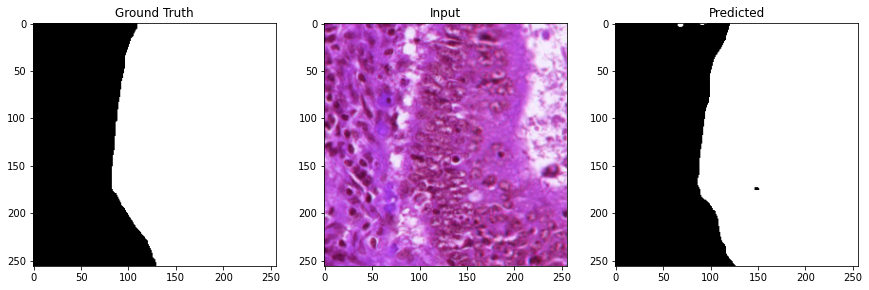

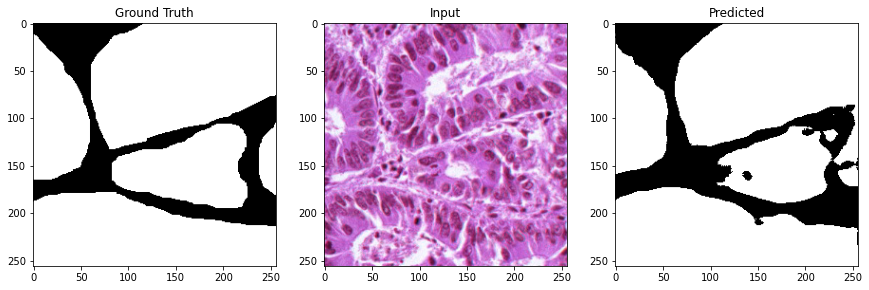

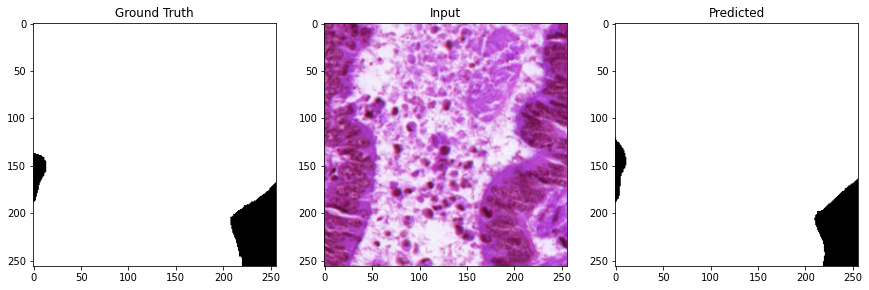

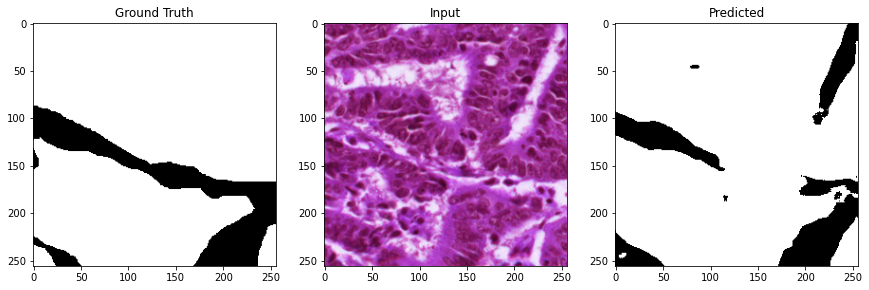

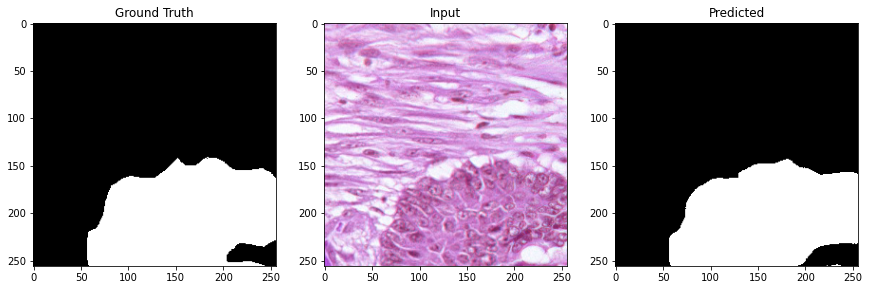

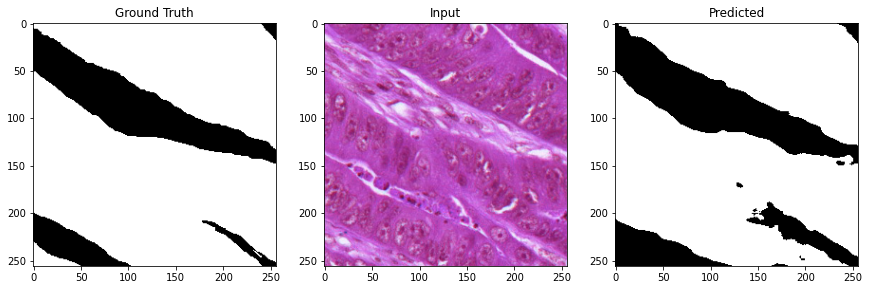

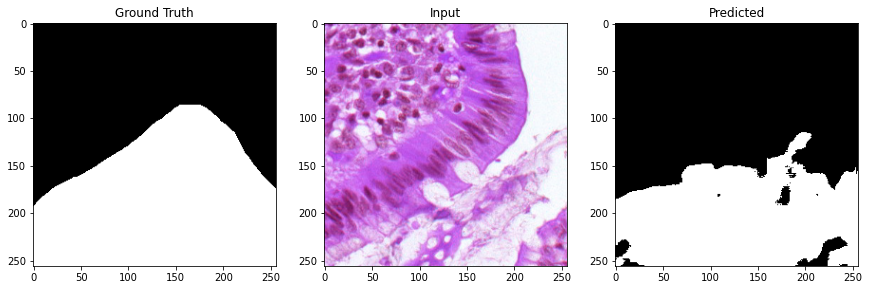

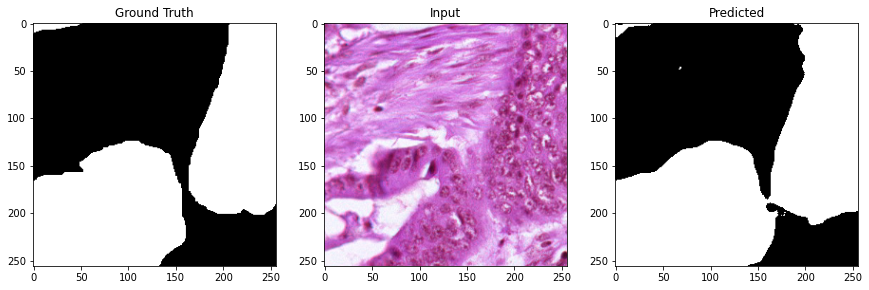

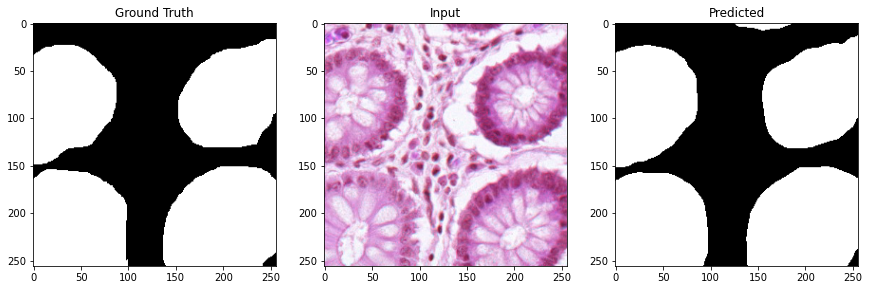

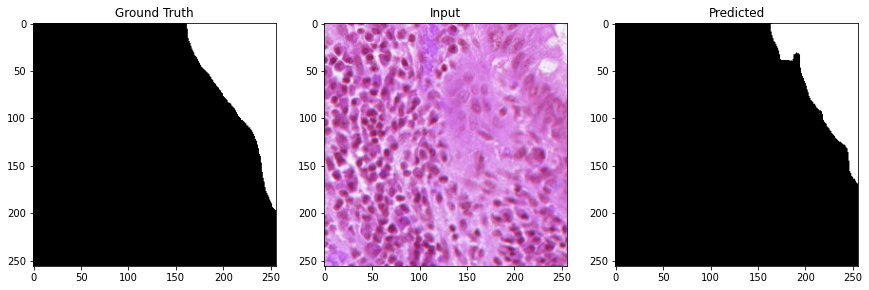

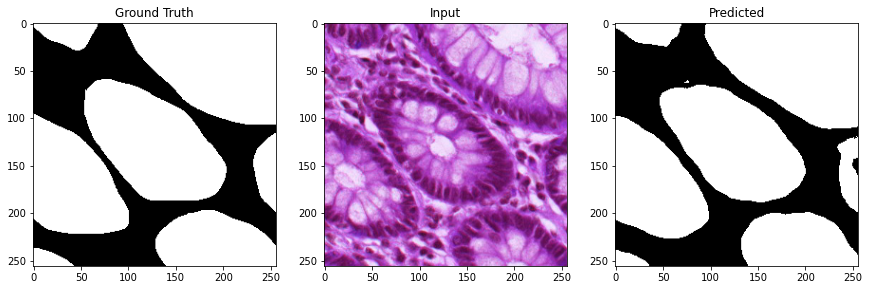

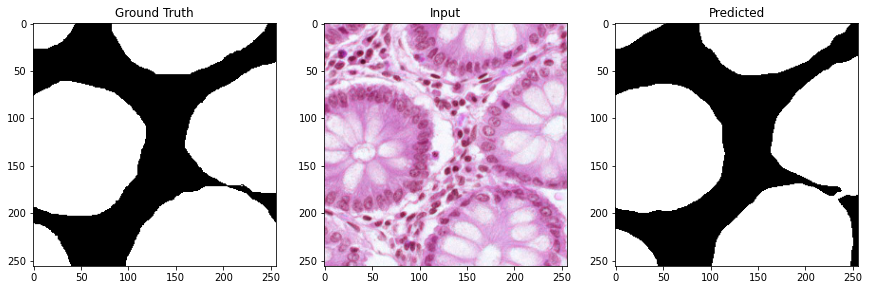

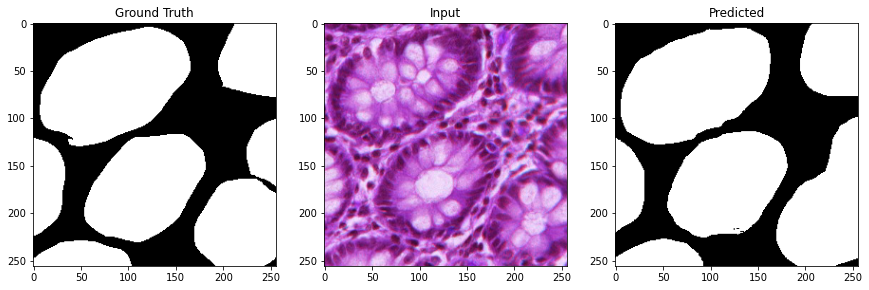

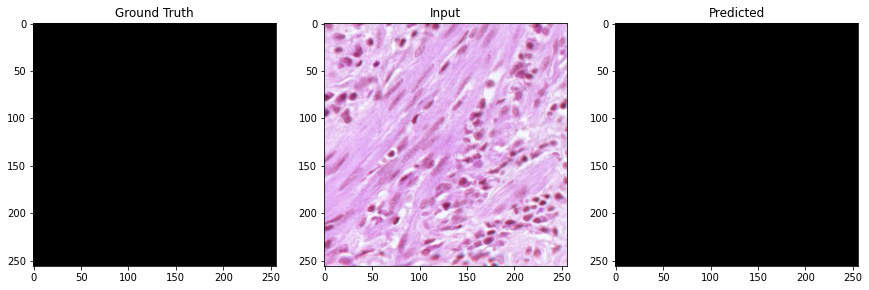

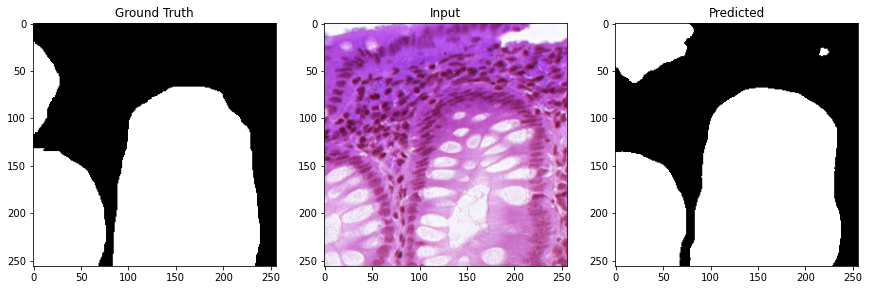

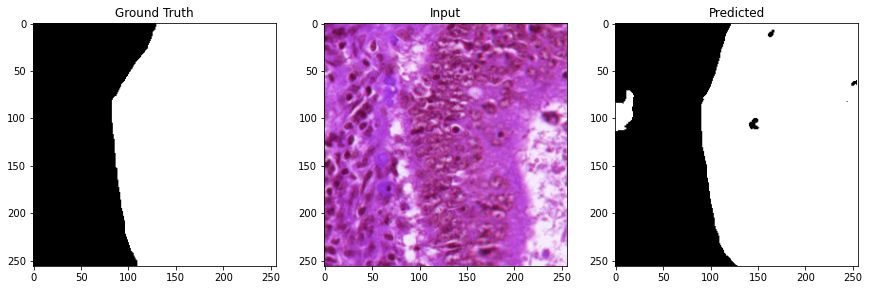

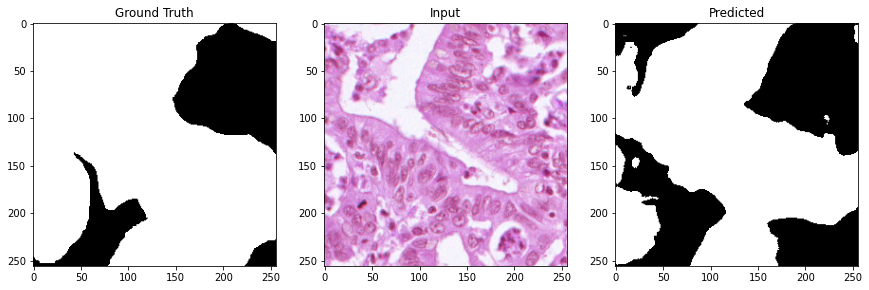

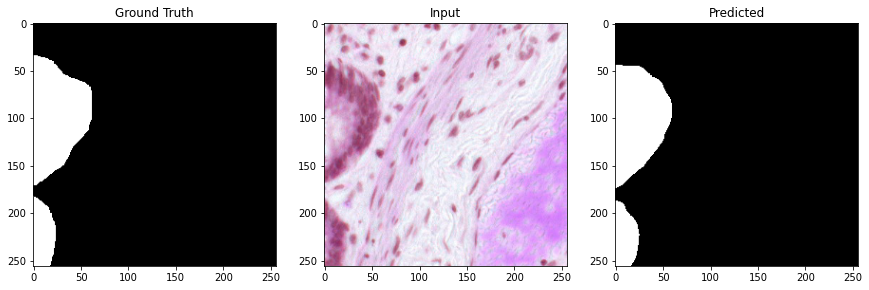

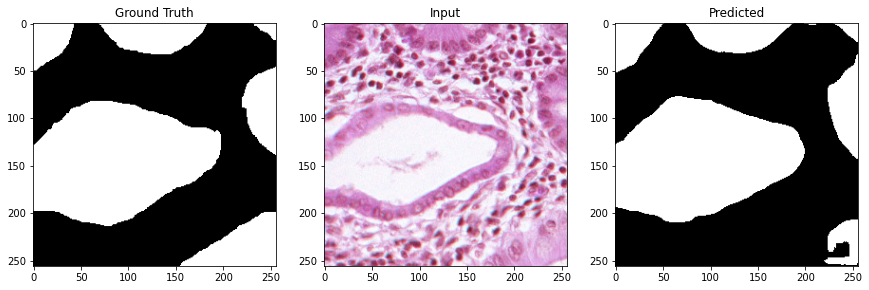

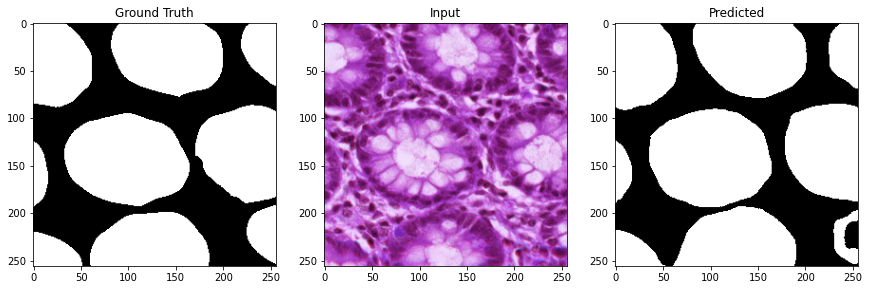

In [26]:
X_Test = x_test.copy()
Y_Test = y_test.copy()

for i in range(20):
  img_gt = X_Test[i]
  msk_gt = Y_Test[i]
  fig = plt.figure(figsize=(20,20))
  
  a = fig.add_subplot(1,4,1)
  a.title.set_text('Ground Truth')
  a.imshow(msk_gt.reshape(256,256), cmap = 'gray')

  a = fig.add_subplot(1,4,2)
  a.title.set_text('Input')
  a.imshow(img_gt)

  a = fig.add_subplot(1,4,3)
  predicted_mask = model.predict(img_gt.reshape(1,256,256,3)).reshape(256,256)
  _,predicted_mask = cv2.threshold(predicted_mask,0.9,1,cv2.THRESH_BINARY)
  predicted_mask = predicted_mask*255
  predicted_mask = predicted_mask.astype(np.uint8)
  a.title.set_text('Predicted')
  a.imshow(predicted_mask, cmap='gray')
